In [1]:

import pandas as pd 
import numpy as np

file_path = "university_admission_requirements.xlsx"


df = pd.read_excel(file_path)

print("BASIC DATASET INFORMATION")
print(f"Number of Rows: {df.shape[0]}")
print(f"Number of Columns: {df.shape[1]}")
print("\nColumn Names:")
print(df.columns.tolist())

print("\nData Types:")
print(df.dtypes)


print("NUMERICAL SUMMARY")
print(df.describe(include=[np.number]))

print("CATEGORICAL SUMMARY")
print(df.describe(include=[object]))


print("FIRST FIVE ROWS OF THE DATASET")
display(df.head())

print("MISSING VALUE CHECK")
print(df.isnull().sum())

import matplotlib.pyplot as plt


if "Region" in df.columns:
    df["Region"].value_counts().plot(kind='bar', figsize=(8,4))
    plt.title("Universities by Region")
    plt.xlabel("Region")
    plt.ylabel("Count")
    plt.show()


BASIC DATASET INFORMATION
Number of Rows: 10
Number of Columns: 10

Column Names:
['University', 'Location (State)', 'Average GRE Required', 'Average TOEFL Required', 'Average IELTS Required', 'Minimum CGPA Required', 'Research Preference', 'Acceptance Rate (%)', 'University Rating (1-5)', 'Program Strength Area']

Data Types:
University                  object
Location (State)            object
Average GRE Required         int64
Average TOEFL Required       int64
Average IELTS Required     float64
Minimum CGPA Required      float64
Research Preference         object
Acceptance Rate (%)          int64
University Rating (1-5)    float64
Program Strength Area       object
dtype: object
NUMERICAL SUMMARY
       Average GRE Required  Average TOEFL Required  Average IELTS Required  \
count             10.000000               10.000000               10.000000   
mean             321.700000              100.800000                6.900000   
std                6.129165                5.672546 

,University,Location (State),Average GRE Required,Average TOEFL Required,Average IELTS Required,Minimum CGPA Required,Research Preference,Acceptance Rate (%),University Rating (1-5),Program Strength Area
0,University of Florida,Florida,315,95,7.0,3.0,Yes,31,4.5,"Engineering, Business"
1,Stanford University,California,330,110,7.5,3.8,Yes,4,5.0,"AI, Computer Science, Engineering"
2,Massachusetts Institute of Technology (MIT),Massachusetts,332,110,7.5,3.9,Yes,5,5.0,"AI, Robotics, Technology"
3,"University of California, Berkeley",California,328,105,7.0,3.7,Yes,11,4.8,"Data Science, Engineering, Physics"
4,"University of California, Los Angeles (UCLA)",California,322,100,7.0,3.6,Yes,14,4.7,"Film, Engineering, Medicine"


MISSING VALUE CHECK
University                 0
Location (State)           0
Average GRE Required       0
Average TOEFL Required     0
Average IELTS Required     0
Minimum CGPA Required      0
Research Preference        0
Acceptance Rate (%)        0
University Rating (1-5)    0
Program Strength Area      0
dtype: int64


In [2]:
import hashlib
import json
import re
from datetime import datetime
import matplotlib.pyplot as plt
from pathlib import Path

valid_ranges = {
    "Average GRE Required": (130, 340),
    "Average TOEFL Required": (0, 120),
    "Average IELTS Required": (0, 9),
    "Minimum CGPA Required": (0, 4),
    "Acceptance Rate (%)": (0, 100),
    "University Rating (1-5)": (1, 5)
}

missing_threshold = 0.2 
imbalance_threshold = 0.85

In [3]:
# RISK MANAGEMENT

missing_summary = df.isnull().mean()
high_missing = missing_summary[missing_summary > missing_threshold]

# Range checks
range_violations = {}
for col, (low, high) in valid_ranges.items():
    if col in df.columns:
        invalid_rows = df[(df[col] < low) | (df[col] > high)]
        if not invalid_rows.empty:
            range_violations[col] = invalid_rows.shape[0]

# Duplicate detection
duplicates = df[df.duplicated()]
duplicate_count = duplicates.shape[0]

# Basic outlier detection
outlier_counts = {}
for col in df.select_dtypes(include=[np.number]):
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outlier_counts[col] = df[(df[col] < lower) | (df[col] > upper)].shape[0]

# Imbalance check
imbalances = {}
for col in df.select_dtypes(include="object").columns:
    counts = df[col].value_counts(normalize=True)
    if not counts.empty and counts.iloc[0] > imbalance_threshold:
        imbalances[col] = round(counts.iloc[0], 2)

# PII Detection
email_pattern = re.compile(r"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}")
phone_pattern = re.compile(r"\d{3}[-.\s]?\d{3}[-.\s]?\d{4}")
pii_hits = []
for col in df.select_dtypes(include="object"):
    for idx, val in df[col].astype(str).items():
        if email_pattern.search(val) or phone_pattern.search(val):
            pii_hits.append((idx, col, val))


In [4]:
# TRUSTWORTHINESS
from datetime import datetime, timezone

with open(file_path, "rb") as f:
    file_hash = hashlib.sha256(f.read()).hexdigest()


audit_report = {
    "timestamp_utc": datetime.now(timezone.utc).isoformat(),
    "file_path": file_path,
    "file_hash": file_hash,
    "rows": df.shape[0],
    "columns": df.shape[1],
    "high_missing_columns": high_missing.to_dict(),
    "range_violations": range_violations,
    "duplicates_found": duplicate_count,
    "outlier_counts": outlier_counts,
    "imbalances_detected": imbalances,
    "pii_hits_count": len(pii_hits),
    "trust_score_estimate": round(
        100
        - (
            len(high_missing) * 5
            + len(range_violations) * 5
            + duplicate_count * 0.1
            + len(imbalances) * 2
            + len(pii_hits) * 10
        ),
        2,
    ),
}


In [5]:
json_path = "data_audit_report.json"
md_path = "data_trustworthiness.md"


with open(json_path, "w") as f:
    json.dump(audit_report, f, indent=4)

# MODEL DEVELOPMENT

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [7]:
print(f"Shape: {df.shape}")
print("\nColumns:\n", df.columns.tolist())

Shape: (10, 10)

Columns:
 ['University', 'Location (State)', 'Average GRE Required', 'Average TOEFL Required', 'Average IELTS Required', 'Minimum CGPA Required', 'Research Preference', 'Acceptance Rate (%)', 'University Rating (1-5)', 'Program Strength Area']


In [8]:
import numpy as np

df["Admission_Label"] = (
    (df["Minimum CGPA Required"] <= 3.4).astype(int)
    + (df["Average GRE Required"] <= 320).astype(int)
    + (df["Average TOEFL Required"] <= 100).astype(int)
    + (df["University Rating (1-5)"] <= 3).astype(int)
)

df["Admission_Label"] = (df["Admission_Label"] >= 2).astype(int)

df["Admission_Label"].value_counts()




Admission_Label
1    6
0    4
Name: count, dtype: int64

Logistic Regression Baseline Results
Accuracy: 1.0
F1 Score: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



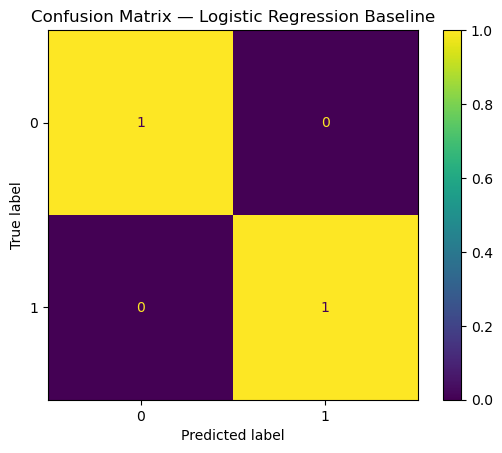

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

num_features = [
    "Average GRE Required",
    "Average TOEFL Required",
    "Average IELTS Required",
    "Minimum CGPA Required",
    "Acceptance Rate (%)",
    "University Rating (1-5)"
]

cat_features = ["University", "Location (State)", "Program Strength Area"]

preprocessor = ColumnTransformer(
    [
        ("num", MinMaxScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)


log_reg = LogisticRegression(
    max_iter=500,
    solver="liblinear"
)

baseline_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", log_reg)
    ]
)

X = df.drop(columns=["Admission_Label"])
y = df["Admission_Label"]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


baseline_pipeline.fit(X_train_b, y_train_b)


y_pred_b = baseline_pipeline.predict(X_test_b)

print("Logistic Regression Baseline Results")
print("Accuracy:", round(accuracy_score(y_test_b, y_pred_b), 3))
print("F1 Score:", round(f1_score(y_test_b, y_pred_b), 3))
print("\nClassification Report:\n", classification_report(y_test_b, y_pred_b))

ConfusionMatrixDisplay.from_estimator(baseline_pipeline, X_test_b, y_test_b)
plt.title("Confusion Matrix — Logistic Regression Baseline")
plt.show()

In [10]:
# MODEL INITIALIZATION

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100, random_state=0
)


In [11]:
# FEATURE ENGINEERING

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_features = [
    "Average GRE Required",
    "Average TOEFL Required",
    "Average IELTS Required",
    "Minimum CGPA Required",
    "Acceptance Rate (%)",
    "University Rating (1-5)"
]
cat_features = ["University", "Location (State)", "Program Strength Area"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ]
)

rf_model = RandomForestClassifier(
    n_estimators=200,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", rf_model)
])

In [12]:
# EVALUATION
X = df.drop(columns=["Admission_Label"])
y = df["Admission_Label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipeline.fit(X_train, y_train)

print("Training distribution:\n", y_train.value_counts())
print("Test distribution:\n", y_test.value_counts())

Training distribution:
 Admission_Label
1    5
0    3
Name: count, dtype: int64
Test distribution:
 Admission_Label
0    1
1    1
Name: count, dtype: int64


In [13]:
df["Program_Description"] = (
    df["University"].astype(str)
    + " | Program Area: " + df["Program Strength Area"].astype(str)
    + " | Location: " + df["Location (State)"].astype(str)
)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline



num_features = [
    "Average GRE Required",
    "Average TOEFL Required",
    "Average IELTS Required",
    "Minimum CGPA Required",
    "Acceptance Rate (%)",
    "University Rating (1-5)"
]

cat_features = ["University", "Location (State)", "Program Strength Area"]

text_feature = "Program_Description"

preprocessor_tfidf = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
        ("text", TfidfVectorizer(max_features=300), text_feature)
    ]
)

rf_model_tfidf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

pipeline_tfidf = Pipeline([
    ("preprocess", preprocessor_tfidf),
    ("model", rf_model_tfidf)
])

X = df.drop(columns=["Admission_Label"])
y = df["Admission_Label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipeline_tfidf.fit(X_train, y_train)

y_pred = pipeline_tfidf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Accuracy: 1.0
F1 Score: 1.0


In [15]:
print("MODEL COMPARISON")
print(f"Logistic Regression Accuracy: {round(accuracy_score(y_test_b, y_pred_b), 3)}")
print(f"Logistic Regression F1 Score: {round(f1_score(y_test_b, y_pred_b), 3)}")

y_pred_tfidf = pipeline_tfidf.predict(X_test)
acc_tfidf = accuracy_score(y_test, y_pred_tfidf)
f1_tfidf = f1_score(y_test, y_pred_tfidf)

print("Random Forest (TF-IDF) Accuracy:", round(acc_tfidf, 3))
print("Random Forest (TF-IDF) F1 Score:", round(f1_tfidf, 3))


MODEL COMPARISON
Logistic Regression Accuracy: 1.0
Logistic Regression F1 Score: 1.0
Random Forest (TF-IDF) Accuracy: 1.0
Random Forest (TF-IDF) F1 Score: 1.0


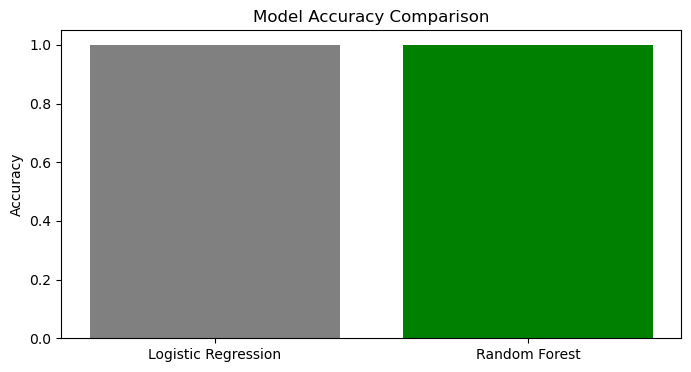

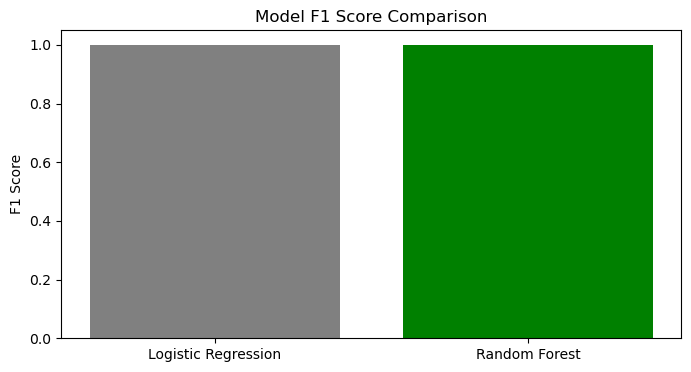

In [16]:
import matplotlib.pyplot as plt

models = ["Logistic Regression", "Random Forest"]
accuracies = [accuracy_score(y_test_b, y_pred_b), acc_tfidf]
f1s = [f1_score(y_test_b, y_pred_b), f1_tfidf]

plt.figure(figsize=(8,4))
plt.bar(models, accuracies, color=["gray", "green"])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(8,4))
plt.bar(models, f1s, color=["gray", "green"])
plt.title("Model F1 Score Comparison")
plt.ylabel("F1 Score")
plt.show()


In [17]:
from sklearn.metrics import classification_report

y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



In [18]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(pipeline, X, y, cv=3, scoring='accuracy')
print("Cross-validation accuracy scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())


Cross-validation accuracy scores: [1.         1.         0.66666667]
Mean accuracy: 0.8888888888888888


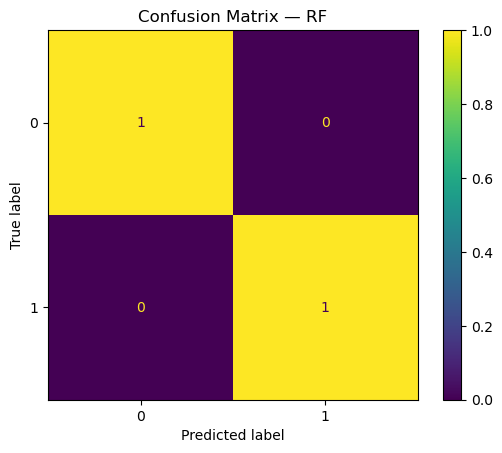

In [19]:
# CONFUSION MATRIX

from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    pipeline, X_test, y_test, labels=[0, 1]
)
plt.title("Confusion Matrix — RF")
plt.show()


In [20]:
# HYPERPARAMETER TUNING


from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt


param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__criterion": ["gini", "entropy", "log_loss"],
    "model__max_depth": [None, 5, 10, 15],
    "model__min_samples_split": [2, 4, 6],
    "model__min_samples_leaf": [1, 2, 3],
}

In [21]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters:")
print(grid_search.best_params_)

print("Best F1 Score:", round(grid_search.best_score_, 3))
best_pipeline = grid_search.best_estimator_
pipeline = best_pipeline


Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Parameters:
{'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best F1 Score: 0.933


In [22]:

y_pred_best = best_pipeline.predict(X_test)

acc_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)

print(f"Accuracy: {acc_best:.3f}")
print(f"F1 Score: {f1_best:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))


Accuracy: 1.000
F1 Score: 1.000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



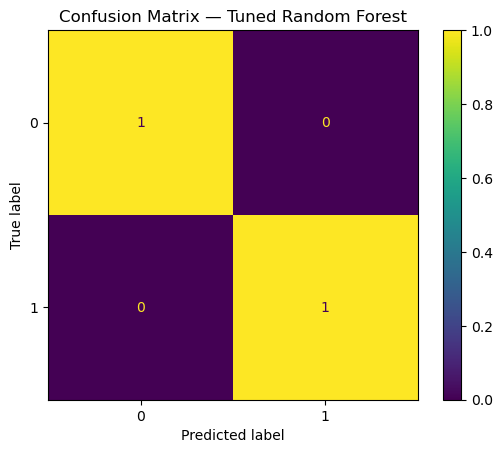

In [23]:
ConfusionMatrixDisplay.from_estimator(best_pipeline, X_test, y_test, labels=[0, 1])
plt.title("Confusion Matrix — Tuned Random Forest")
plt.show()


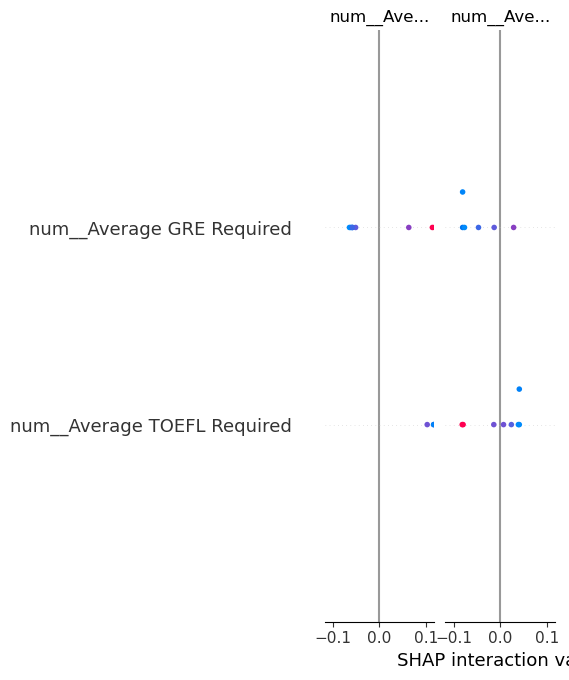

In [24]:
# Explainable AI

import shap
import numpy as np
import matplotlib.pyplot as plt

model_to_explain = best_pipeline.named_steps["model"]
preprocessor = best_pipeline.named_steps["preprocess"]

X_train_transformed = preprocessor.transform(X_train)

explainer = shap.TreeExplainer(model_to_explain)

shap_values = explainer.shap_values(X_train_transformed)

if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_matrix = shap_values[1]
else:
    shap_matrix = shap_values

feature_names = preprocessor.get_feature_names_out()

shap.summary_plot(
    shap_matrix,
    X_train_transformed,
    feature_names=feature_names,
    plot_size=(12, 6)
)


In [25]:
# Fairness and Bias Evaluation

from fairlearn.metrics import (
    MetricFrame,
    selection_rate,
    accuracy_score_group_min,
    demographic_parity_difference
)

model_for_fairness = best_pipeline

group_feature = X_test["Location (State)"]

metric_frame = MetricFrame(
    metrics={"accuracy": accuracy_score},
    y_true=y_test,
    y_pred=model_for_fairness.predict(X_test),
    sensitive_features=group_feature
)

print("Fairness Evaluation (by State):")
print(metric_frame.by_group)

print("\nOverall Accuracy:", metric_frame.overall["accuracy"])

print(
    "Minimum Group Accuracy:",
    accuracy_score_group_min(
        y_true=y_test,
        y_pred=model_for_fairness.predict(X_test),
        sensitive_features=group_feature
    )
)

print(
    "Demographic Parity Difference:",
    demographic_parity_difference(
        y_true=y_test,
        y_pred=model_for_fairness.predict(X_test),
        sensitive_features=group_feature
    )
)



Fairness Evaluation (by State):
                  accuracy
Location (State)          
California             1.0
Illinois               1.0

Overall Accuracy: 1.0
Minimum Group Accuracy: 1.0
Demographic Parity Difference: 1.0


In [26]:
import joblib

joblib.dump(best_pipeline, "admit_guide_random_forest.pkl")

['admit_guide_random_forest.pkl']

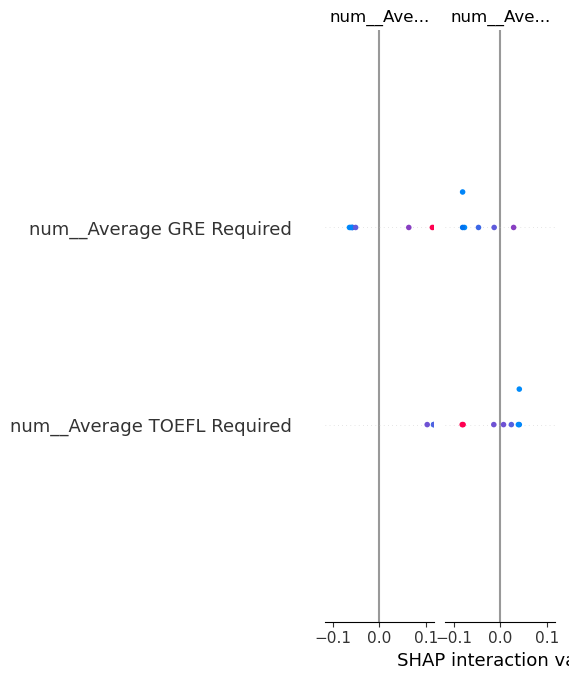

In [27]:
shap.summary_plot(shap_matrix, X_train_transformed,
                  feature_names=best_pipeline.named_steps["preprocess"].get_feature_names_out(),
                  show=False)
plt.savefig("shap_summary.png", dpi=300)

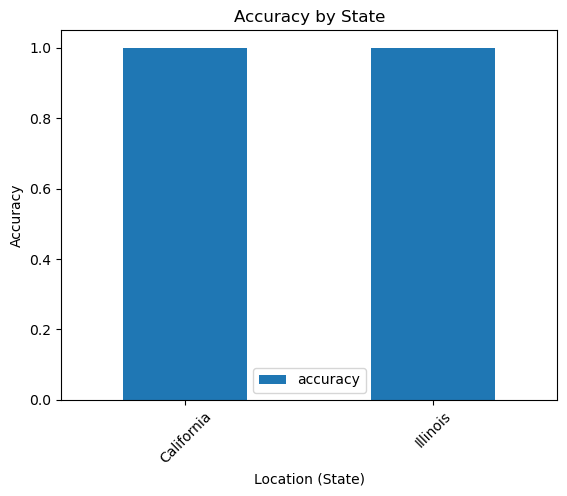

In [28]:
metric_frame.by_group.plot.bar(rot=45, title="Accuracy by State")
plt.ylabel("Accuracy")
plt.savefig("fairness_plot.png", dpi=300)


In [29]:
import gradio as gr
import pandas as pd
import numpy as np

if "Program_Description" not in df.columns:
    df["Program_Description"] = (
        df["University"].astype(str)
        + " | Program Area: " + df["Program Strength Area"].astype(str)
        + " | Location: " + df["Location (State)"].astype(str)
    )

model = pipeline_tfidf
preprocess = model.named_steps["preprocess"]

tfidf_model = preprocess.named_transformers_["text"]

corpus_tfidf = tfidf_model.transform(df["Program_Description"].astype(str))

states_list = [
    "Unknown", "California", "Florida", "New York", "Texas", "Washington",
    "Illinois", "Georgia", "Pennsylvania", "Ohio","Michigan"
]

state_choices_for_filter = ["Any"] + sorted(
    [s for s in df["Location (State)"].dropna().unique().tolist()
     if isinstance(s, str)]
)



def predict_admission_student(gre, toefl, ielts, cgpa, university, state, feedback):
    try:
        
        uni_row = df[df["University"].str.lower() == str(university).lower()].reset_index(drop=True)

        if uni_row.empty:
            return "<b> University not found in dataset. Please enter a valid name.</b>"

        req_gre = float(uni_row["Average GRE Required"][0])
        req_toefl = float(uni_row["Average TOEFL Required"][0])
        req_ielts = float(uni_row["Average IELTS Required"][0])
        req_cgpa = float(uni_row["Minimum CGPA Required"][0])


        match_score = (
            int(gre >= req_gre) +
            int(toefl >= req_toefl) +
            int(ielts >= req_ielts) +
            int(cgpa >= req_cgpa)
        )


        user_row = pd.DataFrame([{
            "Average GRE Required": req_gre,
            "Average TOEFL Required": req_toefl,
            "Average IELTS Required": req_ielts,
            "Minimum CGPA Required": req_cgpa,
            "Acceptance Rate (%)": float(uni_row["Acceptance Rate (%)"][0]),
            "University Rating (1-5)": float(uni_row["University Rating (1-5)"][0]),
            "University": str(university),
            "Location (State)": str(state),
            "Program Strength Area": str(uni_row["Program Strength Area"][0]),
            "Program_Description": (
                f"{university} | Program Area: {uni_row['Program Strength Area'][0]} | Location: {state}"
            )
        }])


        difficulty_prob = model.predict_proba(user_row)[0][1]


        final_prob = (0.7 * (match_score / 4.0) + 0.3 * difficulty_prob) * 100
        final_prob = round(final_prob, 2)


        if isinstance(feedback, str) and feedback.strip():
            with open("feedback_log.txt", "a", encoding="utf-8") as f:
                f.write(feedback.strip() + "\n")


        return f"""
        <h3>Admission Evaluation</h3>
        <b>Final Admission Probability:</b> {final_prob}%<br>
        <b>Requirement Match Score:</b> {match_score} / 4<br>
        <b>University Difficulty Score (ML):</b> {round(difficulty_prob * 100, 2)}%<br>
        """

    except Exception as e:
        import traceback
        traceback.print_exc()
        return f"<b> Error during prediction:</b> {e}"


iface_predict = gr.Interface(
    fn=predict_admission_student,
    inputs=[
        gr.Number(label="Your GRE Score"),
        gr.Number(label="Your TOEFL Score"),
        gr.Number(label="Your IELTS Score"),
        gr.Number(label="Your CGPA"),
        gr.Textbox(label="University You Are Applying To"),
        gr.Dropdown(label="Your Location (State)", choices=states_list, value="Unknown"),
        gr.Textbox(label="Feedback (Optional)")
    ],
    outputs=gr.HTML(label="Prediction Results"),
    title="Admission Prediction",
    description=(
        "Enter your academic profile and the university you wish to apply to.<br>"
        "The system compares your scores with official requirements and uses a TF-IDF based ML model "
        "to estimate your admission probability."
    ),
    allow_flagging="never"
)



def recommend_programs(interest_text, state_filter):
    try:
        if not isinstance(interest_text, str) or not interest_text.strip():
            return "<b> Please enter your program or course interest.</b>"


        query_vec = tfidf_model.transform([interest_text])


        sims = (corpus_tfidf @ query_vec.T).toarray().ravel()

        mask = np.ones(len(df), dtype=bool)
        if state_filter != "Any":
            mask &= (df["Location (State)"] == state_filter)

        sims_filtered = sims.copy()
        sims_filtered[~mask] = -1 


        valid_idx = np.where(sims_filtered > 0)[0]

        if len(valid_idx) == 0:
            return "<b>No universities match your interest. Try a broader keyword.</b>"

        sorted_idx = valid_idx[np.argsort(sims_filtered[valid_idx])[::-1]]

        rows_html = ""
        for rank, i in enumerate(sorted_idx, start=1):
            row = df.iloc[i]
            sim_pct = round(sims_filtered[i] * 100, 2)

            rows_html += f"""
            <tr>
                <td>{rank}</td>
                <td>{row['University']}</td>
                <td>{row['Program Strength Area']}</td>
                <td>{row['Location (State)']}</td>
                <td>{row['Average GRE Required']}</td>
                <td>{row['Minimum CGPA Required']}</td>
            </tr>
            """

        html = f"""
        <h3>Matching Universities Based on Your Interest</h3>
        <p>Showing <b>{len(sorted_idx)}</b> matching programs ranked by similarity.</p>
        <table border="1" cellpadding="4" cellspacing="0">
            <tr>
                <th>#</th>
                <th>University</th>
                <th>Program Area</th>
                <th>State</th>
                <th>Avg GRE Required</th>
                <th>Min CGPA Required</th>
            </tr>
            {rows_html}
        </table>
        """

        return html

    except Exception as e:
        import traceback
        traceback.print_exc()
        return f"<b> Error during recommendation:</b> {e}"


iface_recommend = gr.Interface(
    fn=recommend_programs,
    inputs=[
        gr.Textbox(
            label="What program or course are you interested in?",
            placeholder="e.g., Artificial Intelligence, Data Science, Cybersecurity"
        ),
        gr.Dropdown(
            label="Filter by State (Optional)",
            choices=state_choices_for_filter,
            value="Any"
        )
    ],
    outputs=gr.HTML(label="Recommended Universities"),
    title="Program & University Finder",
    description=(
        "Type your interests (e.g., 'machine learning', 'business analytics').<br>"
        "The system uses TF-IDF text similarity over program descriptions to find the most relevant universities."
    ),
    allow_flagging="never"
)


demo = gr.TabbedInterface(
    [iface_predict, iface_recommend],
    ["Admission Prediction", "Program Finder"]
)

demo.launch(share=True)


C:\Users\cbram\anaconda3\Lib\site-packages\gradio\interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(
C:\Users\cbram\anaconda3\Lib\site-packages\gradio\interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.
